In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing, ensemble
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
% matplotlib inline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
rf = RandomForestClassifier()
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, auc
from sklearn.cross_validation import cross_val_score, StratifiedKFold

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dfpa2 = pd.read_csv('/Users/Red/Desktop/GA/Cap/Pennsylvania_Bridges.csv')
dfm = pd.read_csv('/Users/Red/Desktop/GA/Cap/BridgesMass.csv')

/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,10,19,33,34,35,42,82,85,96,115,134,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def eda_helper(df):
    dict_list = []
    for col in df.columns:
        data = df[col]
        dict_ = {}
        # The null count for a column. Columns with no nulls are generally more interesting
        dict_.update({"null_count" : data.isnull().sum()})
        # Counting the unique values in a column
        # This is useful for seeing how interesting the column might be as a feature
        dict_.update({"unique_count" : len(data.unique())})
        # Finding the types of data in the column
        # This is useful for finding out potential problems with a column having strings and ints
        dict_.update({"data_type" : set([type(d).__name__ for d in data])})
        #dict_.update({"score" : match[1]})
        dict_list.append(dict_)
    eda_df = pd.DataFrame(dict_list)
    eda_df.index = df.columns
    #eda_df = eda_df.sort_values(['null_count','unique_count'], ascending=[True, False])
    return eda_df

In [4]:
dfpa_ = dfpa2[['X','Y','CTY_CODE','ADTTOTAL','BRIDGE_ID','COVERED_BRIDGE','CUSTODIAN','DECK_AREA','DECKWIDTH', 'DEPT_MAIN_MATERIAL_TYPE'
               , 'DEPT_MAIN_PHYSICAL_TYPE', 'DESIGNMAIN', 'HISTSIGN', 'LENGTH', 'MATERIALMAIN', 
               'NBI_RATING', 'STATE_LOCAL', 'STRRATING', 'YEARBUILT', 'YEARRECON', 'FLOOD_INSP', 'KIND_HWY']] 

In [33]:
eda_helper(dfpa_)

,data_type,null_count,unique_count
X,{float64},0,27108
Y,{float64},0,26952
CTY_CODE,{int64},0,67
ADTTOTAL,{float64},0,8208
BRIDGE_ID,"{int, str}",0,27149
COVERED_BRIDGE,{float64},0,2
CUSTODIAN,{float64},0,15
DECK_AREA,{float64},0,12010
DECKWIDTH,{float64},0,985
DEPT_MAIN_MATERIAL_TYPE,{float64},0,9


In [32]:
dfpa_ = dfpa_.dropna()
dfpa_ = dfpa_.drop('NBI_RATING_RATING', axis=1)

In [34]:
dfpa_.NBI_RATING.value_counts()

0.0    17875
1.0     9274
Name: NBI_RATING, dtype: int64

In [8]:
dfpa_['HISTSIGN'] = dfpa_['HISTSIGN'].replace({'!':0, '5':0, '4':0, '3':0, '2':1})
dfpa_['CUSTODIAN'] = dfpa_['CUSTODIAN'].replace({'XX':0})
dfpa_['STATE_LOCAL'] = dfpa_['STATE_LOCAL'].replace({'S':1,'L':0})

In [29]:
dfpa_['NBI_RATING'] = dfpa_['NBI_RATING'].replace({2:1})

In [10]:
dfpa_=dfpa_[dfpa_.STRRATING != 'N']
dfpa_=dfpa_[dfpa_.KIND_HWY != 'N']
dfpa_=dfpa_[dfpa_.KIND_HWY !='!']

In [13]:
dfpa_.HISTSIGN = dfpa_.HISTSIGN.astype(float)
dfpa_.CUSTODIAN = dfpa_.CUSTODIAN.astype(float)
dfpa_.STRRATING = dfpa_.STRRATING.astype(float)
dfpa_.KIND_HWY = dfpa_.KIND_HWY.astype(float)

In [17]:
X = dfpa_.drop(['HISTSIGN', 'BRIDGE_ID'], axis = 1)
y = dfpa_.HISTSIGN

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 8)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21719, 20), (5430, 20), (21719,), (5430,))

Feature ranking:
1. feature X (0.092955)
2. feature Y (0.084235)
3. feature CTY_CODE (0.076470)
4. feature ADTTOTAL (0.074807)
5. feature COVERED_BRIDGE (0.071912)
6. feature CUSTODIAN (0.070305)
7. feature DECK_AREA (0.064610)
8. feature DECKWIDTH (0.059143)
9. feature DEPT_MAIN_MATERIAL_TYPE (0.056862)
10. feature DEPT_MAIN_PHYSICAL_TYPE (0.052432)
11. feature DESIGNMAIN (0.046092)
12. feature LENGTH (0.040967)
13. feature MATERIALMAIN (0.040962)
14. feature NBI_RATING (0.031365)
15. feature STATE_LOCAL (0.030653)
16. feature STRRATING (0.028156)
17. feature YEARBUILT (0.026504)
18. feature YEARRECON (0.020367)
19. feature FLOOD_INSP (0.017162)
20. feature KIND_HWY (0.014039)


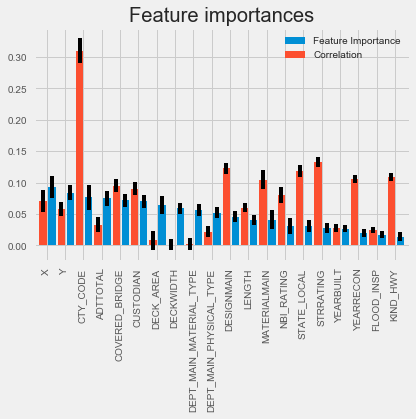

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
plt.style.use('fivethirtyeight')

def feature_importance_eda(X, y):
    
    '''Get an estimate of the feature importance of data'''
    
    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    
    #For correlation comparison
    data = pd.concat([X, y], axis=1)
    d = abs(data.corr().iloc[:,-1][:-1])
    
    features = []
    columns = []
    for f, col in enumerate(X.columns):
        print("%d. feature %s (%f)" % (f + 1, col, importances[indices[f]]))
        feature = [col, importances[indices[f]], d[col]]
        features.append(feature)
        columns.append(col)
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar([(x+0.5)*2 for x in range(X.shape[1])], importances[indices],
            yerr=std[indices], label='Feature Importance')
    
    plt.bar([(x* 2) for x in range(X.shape[1])], d[indices],
            yerr=std[indices], label='Correlation')
    plt.rcParams.update({'font.size': 20})
    plt.xticks([(x*2)+0.4 for x in range(X.shape[1])], columns, rotation='vertical')
    plt.xlim([-1, (2 * X.shape[1])])
    plt.legend()
    plt.show()
    return pd.DataFrame(features, columns=['Feature', 'Importance', 'Correlation'])


#Run function
feature_importance = feature_importance_eda(X, y)

In [22]:
def evaluate_model(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) #accuracy score of model
    con = confusion_matrix(y_test, y_pred) #make a confusion matrix
    crep = classification_report(y_test, y_pred)  #create classifcation report
    
    print con
    print crep
    
    return acc

In [23]:
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1,scoring = 'roc_auc', cv=10)
rfgs.fit(X,y)

print rfgs.best_params_
print rfgs.best_score_
print evaluate_model(rfgs)
print rfgs.best_estimator_

{'min_samples_split': 5, 'n_estimators': 25, 'criterion': 'entropy', 'max_depth': 5, 'class_weight': 'balanced'}
0.962525758753
[[5091  255]
 [  12   72]]
             precision    recall  f1-score   support

        0.0       1.00      0.95      0.97      5346
        1.0       0.22      0.86      0.35        84

avg / total       0.99      0.95      0.96      5430

0.950828729282
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [35]:
X = dfpa_.drop(['NBI_RATING', 'BRIDGE_ID'], axis = 1)
y = dfpa_.NBI_RATING

Feature ranking:
1. feature X (0.318120)
2. feature Y (0.070863)
3. feature CTY_CODE (0.068589)
4. feature ADTTOTAL (0.061052)
5. feature COVERED_BRIDGE (0.058728)
6. feature CUSTODIAN (0.058506)
7. feature DECK_AREA (0.054743)
8. feature DECKWIDTH (0.049141)
9. feature DEPT_MAIN_MATERIAL_TYPE (0.048544)
10. feature DEPT_MAIN_PHYSICAL_TYPE (0.039789)
11. feature DESIGNMAIN (0.031113)
12. feature HISTSIGN (0.030146)
13. feature LENGTH (0.026468)
14. feature MATERIALMAIN (0.018987)
15. feature STATE_LOCAL (0.018120)
16. feature STRRATING (0.014641)
17. feature YEARBUILT (0.012231)
18. feature YEARRECON (0.010621)
19. feature FLOOD_INSP (0.006890)
20. feature KIND_HWY (0.002707)


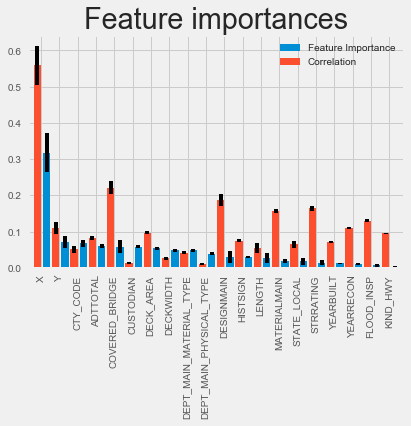

In [37]:
feature_importance = feature_importance_eda(X,y)

In [38]:
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1,scoring = 'roc_auc', cv=10)
rfgs.fit(X,y)

print rfgs.best_params_
print rfgs.best_score_
print evaluate_model(rfgs)
print rfgs.best_estimator_

{'min_samples_split': 5, 'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 5, 'class_weight': None}
0.918948881227
[[5086  260]
 [  13   71]]
             precision    recall  f1-score   support

        0.0       1.00      0.95      0.97      5346
        1.0       0.21      0.85      0.34        84

avg / total       0.99      0.95      0.96      5430

0.949723756906
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [39]:
#dfpa_.to_csv('PAadjusted.csv')

In [40]:
dfpa_ = dfpa_[(dfpa_.YEARBUILT >= 1930) & (dfpa_.YEARBUILT <= 2010)]

In [41]:
#dfpa_.to_csv('PAadjusted1930.csv')

Feature ranking:
1. feature X (0.299668)
2. feature Y (0.087700)
3. feature CTY_CODE (0.066698)
4. feature ADTTOTAL (0.065302)
5. feature COVERED_BRIDGE (0.064854)
6. feature CUSTODIAN (0.059050)
7. feature DECK_AREA (0.053992)
8. feature DECKWIDTH (0.053658)
9. feature DEPT_MAIN_MATERIAL_TYPE (0.049266)
10. feature DEPT_MAIN_PHYSICAL_TYPE (0.044239)
11. feature DESIGNMAIN (0.031178)
12. feature HISTSIGN (0.030858)
13. feature LENGTH (0.019919)
14. feature MATERIALMAIN (0.018392)
15. feature STATE_LOCAL (0.017468)
16. feature STRRATING (0.014425)
17. feature YEARBUILT (0.011717)
18. feature YEARRECON (0.009862)
19. feature FLOOD_INSP (0.001411)
20. feature KIND_HWY (0.000344)


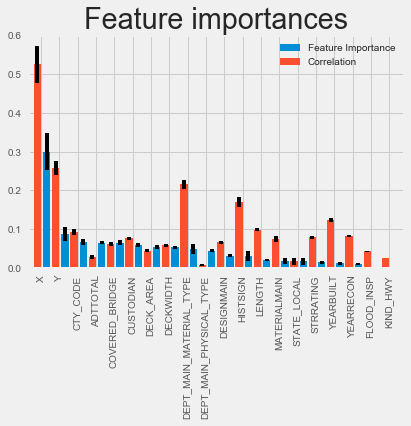

In [42]:
X = dfpa_.drop(['NBI_RATING', 'BRIDGE_ID'], axis = 1)
y = dfpa_.NBI_RATING
feature_importance = feature_importance_eda(X,y)

In [54]:
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1,scoring = 'roc_auc', cv=10)
rfgs.fit(X_test,y_test)

print rfgs.best_params_
print rfgs.best_score_
print evaluate_model(rfgs)
print rfgs.best_estimator_

{'min_samples_split': 5, 'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 5, 'class_weight': 'balanced'}
0.910077281207
[[3127   22]
 [ 634  699]]
             precision    recall  f1-score   support

        0.0       0.83      0.99      0.91      3149
        1.0       0.97      0.52      0.68      1333

avg / total       0.87      0.85      0.84      4482

0.853636769299
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [51]:
def retest(model):
    rtsc = cross_val_score(model, X, y, cv=StratifiedKFold(y, shuffle=True),n_jobs=-1)
    sc = rtsc.std()
    m = rtsc.mean()
    return m, sc

In [52]:
retest(rf)

(0.88473895446863304, 0.002650495203287237)

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_test,y_test)
preds = xgb.predict_proba(X_gb)[:,1]
preds

In [44]:
dfma = dfm[['Latitude','Longitude','Structure_Material', 'Structure_Type', 'Town','Bridge_Owner', 'Bridge_Identification_Number__B' 
            ,'Year_Built', 'Year_Reconstructed', 'Structure_Length', 'Structurally_Deficient', 'Structure_Category']]

In [47]:
eda_helper(dfma)

,data_type,null_count,unique_count
Latitude,{float64},0,7321
Longitude,{float64},0,7374
Structure_Material,{str},0,11
Structure_Type,{str},0,22
Town,{str},0,346
Bridge_Owner,{str},0,2
Bridge_Identification_Number__B,{str},0,7554
Year_Built,{int64},0,170
Year_Reconstructed,{int64},0,111
Structure_Length,{float64},0,1060


In [ ]:
dfma = dfma[dfma.Structurally_Deficient != 'UNKNOWN']

In [ ]:
dfma.Structurally_Deficient = dfma.Structurally_Deficient.replace({'YES':1, 'NO':0})

In [ ]:
dfma.Structure_Category = dfma.Structure_Category.replace({'Bridge (NBI)': 1, 'Short Span Bridge':2, 'Culvert':3})

In [ ]:
dfma.Structure_Material = dfma.Structure_Material.replace({'Steel':1, 'Concrete':2, 'Prestressed concrete':3, 'Steel continuous':4, 
         'Masonry':5, 'Concrete continuous':6, 'Prestressed concrete continuous':7, 'Wood or Timber':8,
                     'Aluminum, Wrought Iron, or Cast Iron':9,'Other':0, '-':0})
dfma.Structure_Material = dfma.Structure_Material.astype(float)

In [ ]:
dfma.Structure_Type = dfma.Structure_Type.replace({'Stringer/Multi-beam or Girder':2, 'Culvert (includes frame culverts)':19, 
                                                   'Slab':1, 'Arch - Deck':11, 'Tee Beam':4, 
                                                   'Box Beam or Girders - Multiple':5, 
                                                   'Box Beam or Girders - Single or Spread':6, 'Frame (except frame culverts)':7,
                                                    'Girder and Floorbeam System':3,'Other':0, '-':0,
                                                  'Truss - Thru':10,'Segmental Box Girder':21,'Movable - Bascule':16,
                                                   'Arch - Thru':12,'Truss - Deck':9,'Mixed types':20,
                                                  'Movable - Swing':17,'Stayed Girder':14,'Movable - Lift':15,
                                                   'Suspension':13,'Channel Beam':22,})

In [ ]:
dfma['Bridge_Owner'] = [1 if x == 'DOT' else 0 for x in dfma.Bridge_Owner]

In [ ]:
Xma = dfma.drop(['Structurally_Deficient', 'Town','Bridge_Identification_Number__B'], axis = 1)
yma = dfma.Structurally_Deficient
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1,scoring = 'roc_auc', cv=10)
rfgs.fit(Xma,yma)

print rfgs.best_params_
print rfgs.best_score_
print evaluate_model(rfgs)
print rfgs.best_estimator_

In [ ]:
feature_importance = feature_importance_eda(Xma, yma)

In [ ]:
from sklearn.model_selection import cross_val_predict
proba = cross_val_predict(rfgs, Xma, yma, cv=3, method='predict_proba')
proba

In [49]:
dfpa = dfpa_[['X','Y','BRIDGE_ID','DEPT_MAIN_MATERIAL_TYPE'
               , 'DESIGNMAIN', 'LENGTH', 'MATERIALMAIN', 
               'NBI_RATING', 'STATE_LOCAL', 'STRRATING', 'YEARBUILT', 'YEARRECON']] 

In [50]:
eda_helper(dfpa)

,data_type,null_count,unique_count
X,{float64},0,22384
Y,{float64},0,22298
BRIDGE_ID,"{int, str}",0,22410
DEPT_MAIN_MATERIAL_TYPE,{float64},0,9
DESIGNMAIN,{float64},0,17
LENGTH,{float64},0,972
MATERIALMAIN,{float64},0,10
NBI_RATING,{float64},0,2
STATE_LOCAL,{int64},0,2
STRRATING,{float64},0,9


In [ ]:
Xpa = dfpa_.drop(['NBI_RATING','BRIDGE_ID'], axis = 1)
ypa = dfpa_.NBI_RATING

In [ ]:
feature_importance = feature_importance_eda(Xpa, ypa)

In [ ]:
rfparams = {'n_estimators':[10, 25, 50,100, 300],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


rfgs = GridSearchCV(rf, rfparams, n_jobs=-1,scoring = 'roc_auc', cv=10)
rfgs.fit(Xpa,ypa)

print rfgs.best_params_
print rfgs.best_score_
print evaluate_model(rfgs)
print rfgs.best_estimator_

Aim: The goal of this project is to understand the process leading up the depreciation of bridges, and the differences between states based off a multitude of factors.
Data Cleaning: For our cleaning process, we examined both sets of data and then based off the table information guide provided by PENNDOT I converted both systems to a similar scale. For my PA exclusive model, I kept more features that I believe may have an influence on the depreciation of a bridge such as city code and average daily traffic. My score noticeably went up for PA in the MA/PA comparison whcih means that my second model is more than likely underfitting and by removing features I am removing features which can be enlightening towards depreciation.
Success Criteria: I wanted to see if I could narrow down the predictors to determine whether or not a bridge which would become deficient and if there would be a substantial difference between states. I was actually hoping for a larger discrepancy, and then attempt to see why. We were able to determine influential factors, and see discrepancy depending on size so for now I'll deem it a success!
For my model selection, I went with random forests. For the amount of features I wanted to incorporate this seemed like the best choice for incorporating all of them.
Current Results: Are that my geographical component has the largest influence on my model, followed by city code and average daily traffic. The 3rd and 4th category make quite a bit of sense to me as city budgets can determine which bridges/infrastructure gets focused on in a given year and may be ignored for a period of time. High daily traffic can also influence which bridges are more likely to fall faster. Latitude and longitude are interesting in that I didn't believe they would have as high of an influence as they ended up having, especially that it would carry over into massachusetts as well. More research necessary to determine actual effects.